# Single and Dual Image FRC
**IIT 2018-06-01**

There are several ways that one can think of splitting a single image into two in a way to produce two similar enough sub-images that can be used for FRC combination. The signal to noise ratio as well as the frequency bandwidth in the sub-images will be lower than in the original image. The former needs to be taken into account with the FRC threshold, whereas the second, ideally at the time of the image acquisition, as undersampling will make successfull splitting impossible.

In [7]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom

import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.ui.frc_options as options
import supertomo.ui.plots.image as showim
import supertomo.data.io.read as read
import supertomo.ui.plots.frc as frcplots
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops

from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
from supertomo.data.containers.image import Image 

import warnings
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")


def checkerboard_split(image):
    """
    Splits an image in two, by using a checkerboard pattern.

    :param image:   a SuperTomo Image
    :return:        two Supertomo Images
    """
    assert isinstance(image, Image)

    # Make an index chess board structure
    shape = image.shape
    odd_index = list(np.arange(1, shape[i], 2) for i in range(len(shape)))
    even_index = list(np.arange(0, shape[i], 2) for i in range(len(shape)))

    # Create the two pseudo images
    if image.ndim == 2:
        image1 = image[odd_index[0], :][:, odd_index[1]]
        image2 = image[even_index[0], :][:, even_index[1]]
    else:
        image1 = image[odd_index[0], :, :][:, odd_index[1], :][:, :, odd_index[2]]
        image2 = image[even_index[0], :, :][:, even_index[1], :][:, :, even_index[2]]

    image1.spacing = tuple(i * np.sqrt(2) for i in image.spacing)
    image2.spacing = image1.spacing

    return image1, image2

## Get Data

The STED images are from Abberior STED system. The two images were acquired in line-by-line manner.

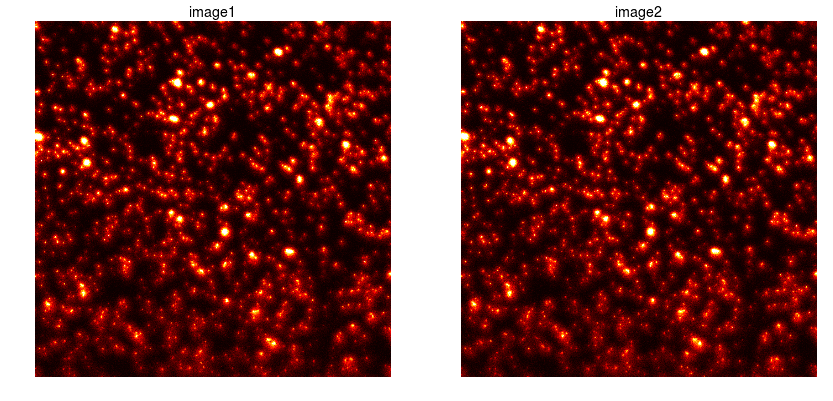

Image shape (1000, 1000) and pixel spacing [0.014999999700000006, 0.014999999700000006]


In [8]:
data_dir = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/Crimson_Beads_2D_FRC_Abberior"
image_name = "Sted.tif"

# Get image
image1 = read.get_image(os.path.join(data_dir, image_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image_name), channel=1)

showim.display_2d_images(imops.enhance_contrast(image1, percent_saturated=0.3), 
                         imops.enhance_contrast(image2, percent_saturated=0.3))


print "Image shape {} and pixel spacing {}".format(image1.shape, image1.spacing)

## Setup FRC

The FRC execution can be modified in several ways, through the *argparse* interface that was originally developed for the command line scripts that was initially the intended UI for the *SuperTomo* package. 

In [9]:
import supertomo.ui.frc_options as options

data_dir = os.path.join(os.getcwd(), "data/2018_01_29_FRC_Nikon_Taka")
args_list = [data_dir, '--bin-delta=10', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=one-bit', '--resolution-threshold-value=0.3', '--use-splines']

args = options.get_frc_script_options(args_list)

print args

Namespace(d_angle=20, d_bin=10.0, d_extract_angle=5.0, debug=False, directory='/Users/sami/Programming/GIT/supertomo2/notebooks/data/2018_01_29_FRC_Nikon_Taka', frc_curve_fit_degree=4, hanning=False, hollow_iterator=False, min_filter=False, normalize_power=False, pathout=None, resol_square=False, resolution_point_sigma=0.01, resolution_threshold_criterion='one-bit', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.3, use_splines=True)


## Run Two Image FRC 

In [10]:
data = FourierCorrelationDataCollection()


frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute() 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

Fit starts at 0.40000000596
Optimization terminated successfully.
         Current function value: 0.000067
         Iterations: 9
         Function evaluations: 18


## Run single image FRC

For the single image FRC the *image1* is split in two with the checkerboard pattern, after which the FRC analysis is run again with the same parameters as above, except for the threshold criterion that is adjusted for the SNR change.


In [11]:
# Make image split
image1_split, image2_split = checkerboard_split(image1)

# Change FRC threshold to compensate for new resolution value
args.resolution_threshold_criterion = "half-bit"

# Run
frc_task_split = frc.FRC(image1_split, image2_split, args.d_bin)
data2 = FourierCorrelationDataCollection()
data2[0] = frc_task_split.execute()

# Analyze and concatenate results
analyzer = fsc_analysis.FourierCorrelationAnalysis(data2, image1_split.spacing[0], args)
results[1] = analyzer.execute()[0]



Fit starts at 0.600000023842
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 10
         Function evaluations: 20


## Results

Both methods also with beads give almost exactly the same result, assuming that the threshold value is appropriately adjusted. The *one-bit* and *half-bit* criteria are quite attractive here, as they are direclty connected to the assumed SNR change (from 1 to 0.5, considering that the sub-images have 1/4th of the signal compared to the original).

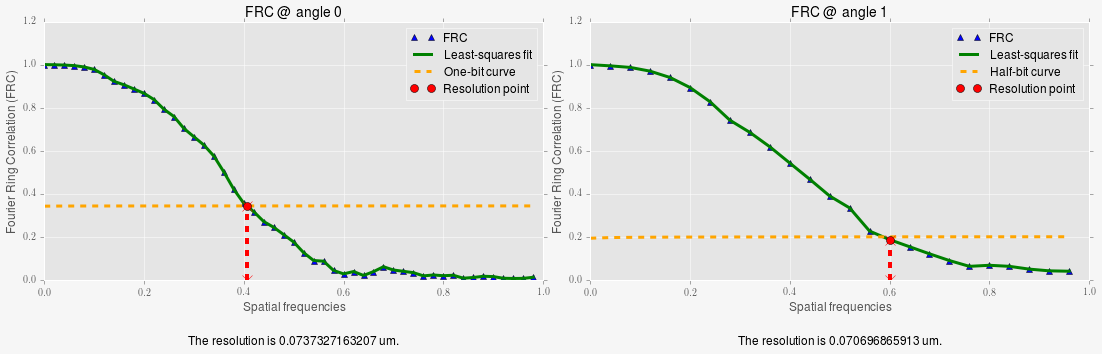

In [12]:
plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()